# An Impedance-based Flow Cytometer Data Analysis:
## Type Differentiation
* This is the work to use **naive bayes approach** for differentiating particle types from read signals
* Data are collected from lock-in amplifier input and feedback output by sensing the differential voltage amplitude due to impedance change.
* Reference signals with three different signals are tested and fed into the non-linear model to classify the outcomes.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

In [2]:
alldata = pd.read_csv('type_differentiation.csv', sep=',')
alldata["label"] = alldata["bead_type"].factorize()[0]
alldata.head()

,bead_type,size,Frequency,Amplitude,Electrode,label
0,Polystyrene,10,20,1.2300,Outin,0
1,Polystyrene,10,20,1.0825,Outin,0
2,Polystyrene,10,20,1.2600,Outin,0
3,Polystyrene,10,20,1.0775,Outin,0
4,Polystyrene,10,20,1.1775,Outin,0


In [5]:
labels = ["Polystyrene", "Silica", "Melamine", "Fe3O4"]
data_20 = []
data_27 = []

for i in range(len(labels)):
    subdata = alldata.loc[alldata.bead_type == labels[i]]
    if labels[i] == "Polystyrene":
        data_20.append(subdata[(subdata["size"] == 6.0) & (subdata["Frequency"] == 20.0)])
        data_27.append(subdata[(subdata["size"] == 6.0) & (subdata["Frequency"] == 27.0)])
    else:
        data_20.append(subdata[subdata["Frequency"] == 20.0])
        data_27.append(subdata[subdata["Frequency"] == 27.0])

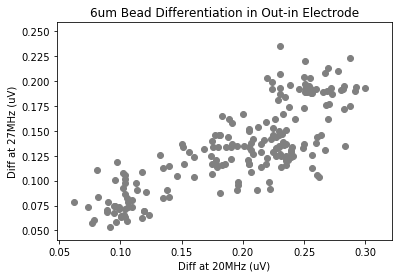

In [6]:
array = []
array1 = []
for i in range(len(labels)):
    x = data_20[i]["Amplitude"].values
    y = data_27[i]["Amplitude"].values
    plt.scatter(x,y,c='grey')
    plt.title("6um Bead Differentiation in Out-in Electrode")
    plt.xlabel("Diff at 20MHz (uV)")
    plt.ylabel("Diff at 27MHz (uV)")
    
    data = np.array([list(x), list(y)]).T
    array.append(data)
    array1.append(data_20[i].label)

plt.show()

X = array[0]
for i in range(1,len(array)):
    X = np.concatenate((X,array[i]), axis=0)
Y = array1[0]
for i in range(1,len(array1)):
    Y = np.concatenate((Y,array1[i]), axis=0)


# Naive-Bayes Generative Modeling

Here we will use bivariate guassian for our classification.

In [7]:
# Random seperate the data
np.random.seed(0)
perm = np.random.permutation(len(Y))
X_train = X[perm[:150],:]
X_test = X[perm[150:],:]
Y_train = Y[perm[:150]]
Y_test = Y[perm[150:]]

## Helper function for visualization and fitting
1. find_range: Find the bounds for a specific dataset
2. fit_guassian: Help to fit a gussian distribution for a specific dataset
3. plot_contours: Plot the data with 2-dimensional data  


**two_features_plot**: combine all three functions

In [8]:
# Find the range within which an array of numbers lie, with a little buffer
def find_range(x):
    lower = min(x)
    upper = max(x)
    width = upper - lower
    lower = lower - 0.2 * width
    upper = upper + 0.2 * width
    return lower, upper

In [9]:
# Fit a Gaussian to a data set using the selected features
def fit_gaussian(x, features):
    mu = np.mean(x[:,features], axis=0)
    covar = np.cov(x[:,features], rowvar=0, bias=1)
    return mu, covar

Next we define a routine that plots a few contour lines of a given two-dimensional Gaussian.
It takes as input:
* `mu`, `cov`: the parameters of the Gaussian
* `x1g`, `x2g`: the grid (along the two axes) at which the density is to be computed
* `col`: the color of the contour lines

In [10]:
def plot_contours(mu, cov, x1g, x2g, col):
    rv = multivariate_normal(mean=mu, cov=cov)
    z = np.zeros((len(x1g),len(x2g)))
    for i in range(0,len(x1g)):
        for j in range(0,len(x2g)):
            z[j,i] = rv.logpdf([x1g[i], x2g[j]]) 
    sign, logdet = np.linalg.slogdet(cov)
    normalizer = -0.5 * (2 * np.log(6.28) + sign * logdet)
    
    plt.contour(x1g,x2g,z, levels=[normalizer-1], colors=col, linewidths=2.0, linestyles='solid')

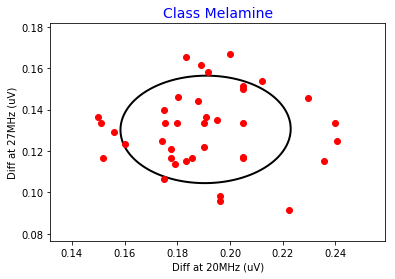

In [11]:
def two_features_plot(f1,f2,label):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(X_train[Y_train==label,f1])
    x2_lower, x2_upper = find_range(X_train[Y_train==label,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    plt.plot(X_train[Y_train==label, f1], X_train[Y_train==label, f2], 'ro')

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Now plot a few contour lines of the density
    mu, cov = fit_gaussian(X_train[Y_train==label,:], [f1,f2])
    plot_contours(mu, cov, x1g, x2g, 'k')
    
    # Finally, display
    plt.xlabel("Diff at 20MHz (uV)")
    plt.ylabel("Diff at 27MHz (uV)")
    plt.title('Class ' + labels[2], fontsize=14, color='blue')
    plt.show()

two_features_plot(0,1,2)

## Fit Guassian for each class
We now define a function that will fit a Gaussian generative model to the three classes, restricted to a given list of features. The function returns:
* `mu`: the means of the Gaussians, one per row
* `covar`: covariance matrices of each of the Gaussians
* `pi`: list of three class weights summing to 1

In [12]:
# Assumes y takes on values 1,2,3
def fit_guassian_all(x, y, features, n):
    
    mu = np.zeros((n,2)) # list of means
    covar = np.zeros((n,2,2)) # list of covariance matrices
    pi = np.zeros(n) # list of class weights
    
    for label in range(n):
        mu[label,:], covar[label,:,:] = fit_gaussian(x[(y==label),:], features)
        pi[label] = float(sum(y==label))/float(len(y))
    
    return mu, covar, pi

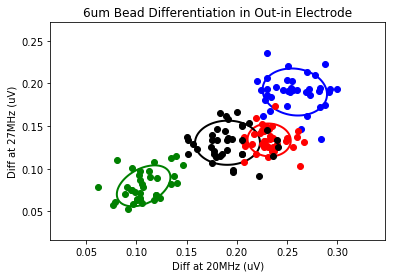

In [13]:
def four_classes_plot(f1,f2):
    if f1 == f2: # we need f1 != f2
        print("Please choose different features for f1 and f2.")
        return  
    
    # Set up plot
    x1_lower, x1_upper = find_range(X_train[:,f1])
    x2_lower, x2_upper = find_range(X_train[:,f2])
    plt.xlim(x1_lower, x1_upper) # limit along x1-axis
    plt.ylim(x2_lower, x2_upper) # limit along x2-axis
    
    # Plot the training points along the two selected features
    colors = ['r', 'k', 'g', 'b']
    for label in range(4):
        plt.plot(X_train[Y_train==label,f1], X_train[Y_train==label,f2], marker='o', ls='None', c=colors[label-1])

    # Define a grid along each axis; the density will be computed at each grid point
    res = 200 # resolution
    x1g = np.linspace(x1_lower, x1_upper, res)
    x2g = np.linspace(x2_lower, x2_upper, res)

    # Show the Gaussian fit to each class, using features f1,f2
    mu, covar, pi = fit_guassian_all(X_train, Y_train, [f1,f2], 4)
    for label in range(4):
        gmean = mu[label,:]
        gcov = covar[label,:,:]
        plot_contours(gmean, gcov, x1g, x2g, colors[label-1])

    # Finally, display
    plt.xlabel("Diff at 20MHz (uV)")
    plt.ylabel("Diff at 27MHz (uV)")
    plt.title("6um Bead Differentiation in Out-in Electrode")
    plt.show()
    
    
    #####################################
    #######Plot decision boundary########
    #####################################
    
#     # Plot the training points along the two selected features
#     colors = ['r', 'k', 'g', 'b']
#     for label in range(4):
#         plt.plot(X_train[Y_train==label,f1], X_train[Y_train==label,f2], marker='o', ls='None', c=colors[label-1])
        
#     rv = {label: multivariate_normal(mean=gmean, cov=gcov) for label in range(4)}    
#     Z = np.zeros((len(x1g), len(x2g)))
#     for i in range(0,len(x1g)):
#         for j in range(0,len(x2g)):
#             scores = []
#             for label in range(4):
#                 scores.append(np.log(pi[label]) + rv[label].logpdf([x1g[i],x2g[j]]))
#             Z[i,j] = np.argmax(scores)

#     # Plot the contour lines
#     plt.contour(x1g,x2g,Z.T,4,cmap='seismic')
#     plt.xlabel("Diff at 20MHz (uV)")
#     plt.ylabel("Diff at 27MHz (uV)")
#     plt.title("6um Bead Differentiation in Out-in Electrode")
#     plt.show()
    

four_classes_plot(0,1)

## Predict labels for the test points
We will now predict the test points label based on our naive-bayes model with guassian distribution.

In [14]:
def test_model(f1, f2):
    if f1 == f2: # need f1 != f2
        print("Please choose different features for f1 and f2.")
        return
    mu, covar, pi = fit_guassian_all(X_train, Y_train, [f1,f2], 4)
    
    n = 4 # Labels 1,2,...,n
    nt = len(X_test) # Number of test points
    score = np.zeros((nt,n))
    for i in range(nt):
        for label in range(n):
            score[i,label] = np.log(pi[label]) + \
            multivariate_normal.logpdf(X_test[i,[f1,f2]], mean=mu[label,:], cov=covar[label,:,:])
    predictions = np.argmax(score, axis=1)
    
    # Finally, tally up score
    # Now test the performance of a predictor based on a subset of features
    errors = np.sum(predictions != Y_test)  
    print("Errors: " + str(errors) + "/" + str(nt))
    print("Test Accuracy: ", 1-errors/nt)
    
    return predictions

Errors: 6/50
Test Accuracy:  0.88
Crosses are where the model has predicted wrong.


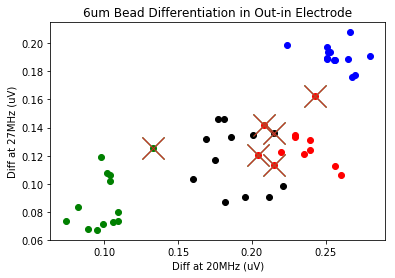

In [15]:
predictions = test_model(0,1)
print("Crosses are where the model has predicted wrong.")
colors = ['r', 'k', 'g', 'b']
for label in range(4):
    plt.plot(X_test[Y_test==label,0], X_test[Y_test==label,1], marker = 'o', ls='None', c=colors[label-1])
    plt.plot(X_test[predictions!=Y_test,0], X_test[predictions!=Y_test,1], marker = 'x', markersize=22, ls='None')

plt.xlabel("Diff at 20MHz (uV)")
plt.ylabel("Diff at 27MHz (uV)")
plt.title("6um Bead Differentiation in Out-in Electrode")
plt.show()